**Instalações necessárias**
- FASE 1: Instalação do python no notebook do colab.

In [ ]:
!pip install -U -q PyDrive

**Importações necessárias**
- FASE 2: Importações das bibliotecas a serem utilizadas.

In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
import shutil
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

**Autenticação de segurança**
- FASE 3: Verificação de acesso do email INTELI para acessar a base de dados fornecida pelo Banco Pan. Importante para a segurança dos dados.

In [ ]:
# Autenticação para acesso aos dados
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Download dos Dados**
- FASE 4: Realização do download dos dados da base para esse notebook do Colab, para a visualização e manipulação.

In [ ]:
# Download dos dados para esta máquina virtual
# downloaded = drive.CreateFile({'id': '1on2f6suP6pWH4HacVFMpYj14LFggYacf'})
# downloaded.GetContentFile("book_variaveis_pan_inteli_v5.zip")
# shutil.unpack_archive("book_variaveis_pan_inteli_v5.zip", "./content/drive/Shareddrives/Grupo-5/book_variaveis_pan_inteli_v5.csv")

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Grupo-5/book_variaveis_pan_inteli_v5.zip")

**Inicio do tratamento dos Dados**
- FASE 5: Seleção de Safra e tratamento inicial das colunas com dados nulos/vazios, como o modelo de treinamento não aceita dados nulos ou strings, essa fase se torna de suma importância e deve ser realizada com calma.
- Isso está sendo feito para a melhor filtragem de dados, e para não consumirmos uma enorme quantidade de processamento.


In [ ]:
#Seleciona uma safra, tira possiveis duplicados e troca o NaN por 0.

df_202104 = df.loc[df['anomes'] == 202104].drop_duplicates(keep='first').fillna(0)

**Tratando Dados**
- FASE 6: Tratamento de valores em formato String da coluna 'cod_rating'. Como citado no passo anterior, um modelo de treinamento não deve possuir strings, sendo assim é necessario fazer o tratamento na coluna 'cod_rating' transformando a escala que antes era "AA, A, B, C, D, E, F, G,H, HH" para "10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0". **Nota: Já que tratamos os valores nulos de toda os campos anteriormente, não é necessario tratar novamente nesta etapa, desta maneira o valor NaN é considerado o valor 0.**

In [ ]:
# Troca de valores escala em string da coluna cod_rating para a escala em formato númerico
df_202104['cod_rating'] = (df_202104['cod_rating'].replace('HH', 1)
                                                  .replace('H', 2)
                                                  .replace('G', 3)
                                                  .replace('F', 4)
                                                  .replace('E', 5)
                                                  .replace('D', 6)
                                                  .replace('C', 7)
                                                  .replace('B', 8)
                                                  .replace('A', 9)
                                                  .replace('AA', 10))

**Ordenar Dados**
- FASE 7: Para a criação do modelo de treinamento, ordenamos os dados tratados com base na coluna de 'ind_atrito' para poder pegar o maior número de linhas que possua valor na coluna diferente de 0. 
- O ordenamento é feito para facilitar a separação entre os clientes com índice atritado 1 e 0, auxiliando o corte dos dados que serão usados no treinamento do modelo.


In [ ]:
#Ordenação dos dados pela coluna ind_atrito
df_202104 = df_202104.sort_values(by=['ind_atrito'],ascending=False)

In [ ]:
df_nova = df
df_nova.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11886345 entries, 0 to 11886344
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   anomes          int64  
 1   num_cpf_hash    object 
 2   vlr_credito     float64
 3   vlr_saldo       float64
 4   num_atend_atrs  float64
 5   vlr_score       float64
 6   num_produtos    float64
 7   num_atend       float64
 8   qtd_oper        float64
 9   qtd_reclm       float64
 10  qtd_restr       float64
 11  vlr_renda       object 
 12  cod_rating      object 
 13  ind_atrito      float64
 14  ind_engaj       float64
 15  ind_novo_cli    float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.4+ GB


In [ ]:
print(df_nova.shape)
df_nova = df_nova.drop_duplicates(keep='first',subset=['num_cpf_hash'])
print(df_nova.shape)
df_nova.ind_atrito.isnull().value_counts()

(11886345, 16)
(987927, 16)


True     987645
False       282
Name: ind_atrito, dtype: int64

**Automatização do número de atritos**
- Função que automatiza a busca do número de clientes atritados por safra, agilizando testes com multiplas safras

In [ ]:
#Automatização de numero de indice de atrito
def num_atritados(safra):
  data = df.loc[df['anomes'] == safra]['ind_atrito'].value_counts()
  num_atrito = pd.Series(data, index = [0, 1])
  if num_atrito[1] == 0:
    return int(num_atrito[0])
  else:
    return int(num_atrito[1])

num_atritados(202104)

257

**Seleção e tratamento de novas safras**
- Resumo das outras safras
- Para serem usados para treino e para teste dos modelos futuros


**Função de seleção e tratamento de safra**
- Para agilizar o processo de seleção e tratamentos de safras , realizamos um função onde é obrigatório passar o paramêtro "anomes', e tem como paramêtro opcional o numero de linhas para o dataframe, caso esse valor não seja passado o dataframe tera 600 linhas.

In [ ]:
def selecao_safra(safra,num_linhas=600):
  safra_selecionada = df.loc[df['anomes'] == safra].drop_duplicates(keep='first').fillna(0)

  # Troca de valores escala em string da coluna cod_rating para a escala em formato númerico
  safra_selecionada['cod_rating'] = (safra_selecionada['cod_rating'].replace('HH', 1)
                                                    .replace('H', 2)
                                                    .replace('G', 3)
                                                    .replace('F', 4)
                                                    .replace('E', 5)
                                                    .replace('D', 6)
                                                    .replace('C', 7)
                                                    .replace('B', 8)
                                                    .replace('A', 9)
                                                    .replace('AA', 10))
  # ordena em ordem decrescente de valor atritado
  safra_selecionada = safra_selecionada.sort_values(by=['ind_atrito'],ascending=False)
  safra_selecionada = safra_selecionada[:num_linhas]
  


  return safra_selecionada

**Seleção dos Dados para Preparação**
- FASE 8: Para os testes e treinamentos a seguir nós usamos a função "selecao_safra", criada acima, para selecionar e preparar a base de dados para ser usada futuramente, facilitando assim a modificação de safra para treinamento e testes de modelos. Usamos a safra 202104 com 600 linhas no dataframe.


In [ ]:
#Retorna os dados reformulados da safra de acordo com o anomes
dados_preparados = selecao_safra(202104,5000)

In [ ]:
dados_preparados['ind_atrito'].value_counts()

0.0    4743
1.0     257
Name: ind_atrito, dtype: int64

**Preparação dos dados**
- Fase 9: Nesta fase procuramos, ainda dar mais uma tratada nos dados para corrigir o campo "vlr_renda" devido ao fato de ter algumas inconsistências neste campo

In [ ]:
dados_preparados['vlr_renda'] = dados_preparados['vlr_renda'].apply(lambda x: str(x.replace(',','.')))

dados_preparados.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
11342364,202104,4cf381b681683ec6a6a6d90e9ee2241648062f8d35847e...,19741.42,4670.96,0.0,183.0,7.0,0.0,32.0,1.0,6.0,6900.00,4,1.0,1.0,0.0
8877844,202104,2d9daed5c2152920bb575b40f137f55649979d455d7a54...,6400.90,499.78,0.0,388.0,4.0,0.0,13.0,1.0,0.0,2200.00,9,1.0,1.0,0.0
9375079,202104,73ed31d33f6e35bdecae8799c1db8e4043a2ab4dc9ac6f...,3200.20,399.63,0.0,389.0,3.0,0.0,16.0,1.0,0.0,1250.00,9,1.0,1.0,0.0
3887432,202104,f6bee44307c0cc548092f7202687334ea558d200d4a814...,29090.48,5910.93,0.0,536.0,7.0,0.0,32.0,1.0,0.0,11700.00,8,1.0,1.0,0.0
3762574,202104,d960800ddd1ad8eda1184c4981db897c546a486bbaad5d...,12631.38,2003.73,0.0,433.0,1.0,0.0,12.0,0.0,1.0,4300.00,9,1.0,0.0,0.0


In [ ]:
dados_preparados.vlr_renda = dados_preparados.vlr_renda.astype('float')

In [ ]:
dados_preparados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11342364 to 8022064
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anomes          5000 non-null   int64  
 1   num_cpf_hash    5000 non-null   object 
 2   vlr_credito     5000 non-null   float64
 3   vlr_saldo       5000 non-null   float64
 4   num_atend_atrs  5000 non-null   float64
 5   vlr_score       5000 non-null   float64
 6   num_produtos    5000 non-null   float64
 7   num_atend       5000 non-null   float64
 8   qtd_oper        5000 non-null   float64
 9   qtd_reclm       5000 non-null   float64
 10  qtd_restr       5000 non-null   float64
 11  vlr_renda       5000 non-null   float64
 12  cod_rating      5000 non-null   int64  
 13  ind_atrito      5000 non-null   float64
 14  ind_engaj       5000 non-null   float64
 15  ind_novo_cli    5000 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 664.1+ KB


**Matriz de correlação**
- Fase 10: Nesta fase, utilizamos os dados preparados para gerar a matriz de correlação

In [ ]:
matriz_corr = dados_preparados.corr().style.background_gradient(cmap='coolwarm')
matriz_corr

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
anomes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vlr_credito,nan,1.000000,0.421688,0.026352,0.317958,0.254217,0.029156,0.533107,0.138332,-0.042908,0.489711,0.358905,0.154108,0.214747,-0.020283
vlr_saldo,nan,0.421688,1.000000,0.003609,0.247024,0.237686,0.006300,0.217814,0.117482,-0.032940,0.170081,0.269855,0.123853,0.169512,-0.025810
num_atend_atrs,nan,0.026352,0.003609,1.000000,0.063797,0.096671,0.752448,0.037319,0.225548,-0.032461,0.005484,0.070350,0.229253,0.103171,-0.005470
vlr_score,nan,0.317958,0.247024,0.063797,1.000000,0.508523,0.071190,0.598587,0.136791,-0.283340,0.179556,0.818934,0.195954,0.440033,0.037310
num_produtos,nan,0.254217,0.237686,0.096671,0.508523,1.000000,0.104850,0.614543,0.121432,-0.122189,0.148289,0.581358,0.177706,0.767529,-0.048299
num_atend,nan,0.029156,0.006300,0.752448,0.071190,0.104850,1.000000,0.055015,0.252839,-0.036180,0.016248,0.082089,0.307506,0.110828,0.005205
qtd_oper,nan,0.533107,0.217814,0.037319,0.598587,0.614543,0.055015,1.000000,0.149131,-0.098769,0.295193,0.656988,0.182901,0.504682,-0.026583
qtd_reclm,nan,0.138332,0.117482,0.225548,0.136791,0.121432,0.252839,0.149131,1.000000,-0.038826,0.086351,0.150884,0.737202,0.186411,0.001069
qtd_restr,nan,-0.042908,-0.032940,-0.032461,-0.283340,-0.122189,-0.036180,-0.098769,-0.038826,1.000000,-0.028056,-0.234213,-0.059065,-0.104661,-0.007405


In [ ]:
target_corr = matriz_corr.data.ind_atrito
df_corr = target_corr.abs().sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')
df_corr

,ind_atrito
ind_atrito,1.000000
qtd_reclm,0.737202
num_atend,0.307506
num_atend_atrs,0.229253
ind_engaj,0.207734
cod_rating,0.207641
vlr_score,0.195954
qtd_oper,0.182901
num_produtos,0.177706
vlr_credito,0.154108


In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
colunas= ['qtd_reclm','num_atend_atrs','num_atend','ind_atrito','vlr_score','num_produtos','vlr_renda','ind_engaj']
data = dados_preparados[colunas].sample(frac=0.9, random_state=786)
data_unseen = dados_preparados.drop(data.index)

In [ ]:
data['ind_atrito'].value_counts()

0.0    4275
1.0     225
Name: ind_atrito, dtype: int64

Comparação dos modelos
- Fase 11: Utilização do pycaret para testar todos os modelos de classificação que podemos utilizar para criar no IA, retornando o resultado de cada tipo e dizem qual é o melhor possível.

In [ ]:
from pycaret.classification import *

exp_1 = setup(data,target='ind_atrito')

,Description,Value
0,session_id,5696
1,Target,ind_atrito
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(4500, 8)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='ind_atrito', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_s...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9784,0.9149,0.5563,0.9875,0.7068,0.6967,0.7302,0.035
ridge,Ridge Classifier,0.9778,0.0000,0.5429,0.9857,0.6945,0.6843,0.7200,0.036
ada,Ada Boost Classifier,0.9775,0.8966,0.5696,0.9369,0.7058,0.6949,0.7196,0.255
lightgbm,Light Gradient Boosting Machine,0.9762,0.8567,0.5829,0.8870,0.6972,0.6855,0.7050,0.159
lr,Logistic Regression,0.9759,0.9158,0.5096,0.9800,0.6469,0.6372,0.6797,0.566
rf,Random Forest Classifier,0.9756,0.8439,0.5700,0.8884,0.6884,0.6764,0.6976,0.757
gbc,Gradient Boosting Classifier,0.9755,0.8996,0.5892,0.8698,0.6947,0.6826,0.7007,0.432
et,Extra Trees Classifier,0.9730,0.8431,0.5896,0.7992,0.6735,0.6599,0.6708,0.712
nb,Naive Bayes,0.9609,0.9068,0.6221,0.6004,0.6050,0.5846,0.5880,0.035
dt,Decision Tree Classifier,0.9584,0.7904,0.6092,0.5615,0.5834,0.5616,0.5626,0.043


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
gbc = create_model('gbc')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9714,0.9056,0.5333,0.8000,0.6400,0.6257,0.6397
1,0.9683,0.9207,0.6667,0.6667,0.6667,0.6500,0.6500
2,0.9746,0.9079,0.4667,1.0000,0.6364,0.6250,0.6742
3,0.9810,0.9112,0.6000,1.0000,0.7500,0.7407,0.7670
4,0.9746,0.8634,0.5333,0.8889,0.6667,0.6543,0.6775
5,0.9841,0.9629,0.8000,0.8571,0.8276,0.8193,0.8198
6,0.9683,0.8994,0.4667,0.7778,0.5833,0.5679,0.5880
7,0.9746,0.8563,0.5333,0.8889,0.6667,0.6543,0.6775
8,0.9778,0.8901,0.6250,0.9091,0.7407,0.7295,0.7436


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5696, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9746,0.9106,0.4667,1.00,0.6364,0.6250,0.6742
1,0.9714,0.9207,0.5333,0.80,0.6400,0.6257,0.6397
2,0.9746,0.8858,0.4667,1.00,0.6364,0.6250,0.6742
3,0.9810,0.9491,0.6000,1.00,0.7500,0.7407,0.7670
4,0.9746,0.8954,0.4667,1.00,0.6364,0.6250,0.6742
5,0.9905,0.9629,0.8000,1.00,0.8889,0.8840,0.8900
6,0.9556,0.9091,0.0667,1.00,0.1250,0.1198,0.2524
7,0.9746,0.9120,0.4667,1.00,0.6364,0.6250,0.6742
8,0.9778,0.9250,0.5625,1.00,0.7200,0.7094,0.7414


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5696, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9714,0.8858,0.4667,0.8750,0.6087,0.5953,0.6272
1,0.9683,0.8176,0.6000,0.6923,0.6429,0.6263,0.6281
2,0.9746,0.8331,0.5333,0.8889,0.6667,0.6543,0.6775
3,0.9810,0.8871,0.6000,1.0000,0.7500,0.7407,0.7670
4,0.9683,0.8187,0.5333,0.7273,0.6154,0.5992,0.6071
5,0.9873,0.8687,0.8000,0.9231,0.8571,0.8505,0.8529
6,0.9746,0.8006,0.4667,1.0000,0.6364,0.6250,0.6742
7,0.9746,0.8833,0.5333,0.8889,0.6667,0.6543,0.6775
8,0.9714,0.7858,0.5000,0.8889,0.6400,0.6263,0.6546


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5696, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_gbc = tune_model(gbc)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9746,0.8949,0.4667,1.0000,0.6364,0.6250,0.6742
1,0.9714,0.9109,0.4667,0.8750,0.6087,0.5953,0.6272
2,0.9746,0.8816,0.4667,1.0000,0.6364,0.6250,0.6742
3,0.9810,0.9209,0.6000,1.0000,0.7500,0.7407,0.7670
4,0.9778,0.8542,0.5333,1.0000,0.6957,0.6852,0.7219
5,0.9905,0.9453,0.8000,1.0000,0.8889,0.8840,0.8900
6,0.9746,0.9009,0.4667,1.0000,0.6364,0.6250,0.6742
7,0.9746,0.9044,0.5333,0.8889,0.6667,0.6543,0.6775
8,0.9746,0.8643,0.5000,1.0000,0.6667,0.6550,0.6978


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=11,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.002, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=260,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5696, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9746,0.9130,0.4667,1.0000,0.6364,0.6250,0.6742
1,0.9746,0.9236,0.6000,0.8182,0.6923,0.6794,0.6883
2,0.9746,0.8558,0.4667,1.0000,0.6364,0.6250,0.6742
3,0.9587,0.9396,0.1333,1.0000,0.2353,0.2266,0.3575
4,0.9778,0.8979,0.5333,1.0000,0.6957,0.6852,0.7219
5,0.9587,0.9453,0.1333,1.0000,0.2353,0.2266,0.3575
6,0.9556,0.9091,0.0667,1.0000,0.1250,0.1198,0.2524
7,0.9746,0.9116,0.4667,1.0000,0.6364,0.6250,0.6742
8,0.9778,0.9174,0.5625,1.0000,0.7200,0.7094,0.7414


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 7
INFO:logs:LogisticRegression(C=7.964, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5696, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
tuned_rf = tune_model(rf) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9746,0.8970,0.4667,1.0000,0.6364,0.6250,0.6742
1,0.9714,0.9236,0.4000,1.0000,0.5714,0.5594,0.6232
2,0.9746,0.9256,0.4667,1.0000,0.6364,0.6250,0.6742
3,0.9810,0.9322,0.6000,1.0000,0.7500,0.7407,0.7670
4,0.9778,0.8784,0.5333,1.0000,0.6957,0.6852,0.7219
5,0.9873,0.9578,0.7333,1.0000,0.8462,0.8397,0.8507
6,0.9746,0.9007,0.4667,1.0000,0.6364,0.6250,0.6742
7,0.9714,0.9117,0.4667,0.8750,0.6087,0.5953,0.6272
8,0.9746,0.9375,0.5000,1.0000,0.6667,0.6550,0.6978


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 8
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=290,
                       n_jobs=-1, oob_score=False, random_state=5696, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


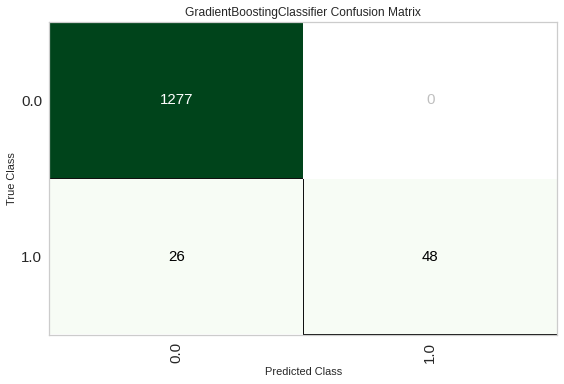

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbc, plot='confusion_matrix')

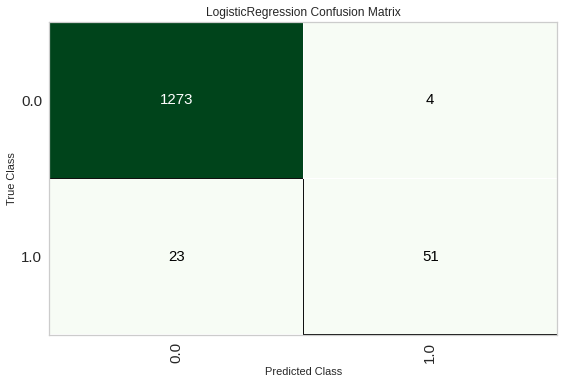

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lr, plot='confusion_matrix')

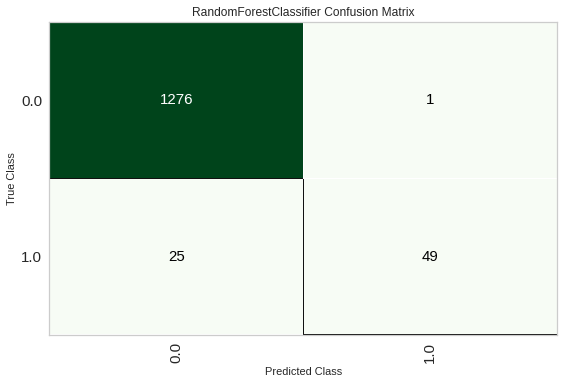

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot='confusion_matrix')

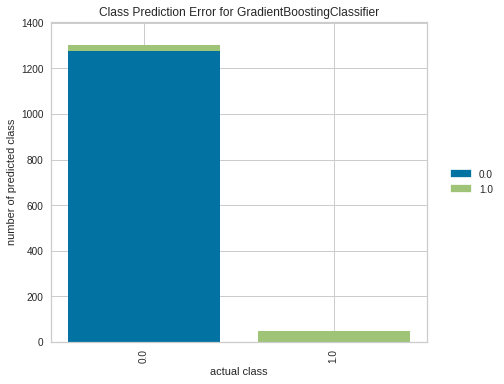

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbc, plot = 'error')

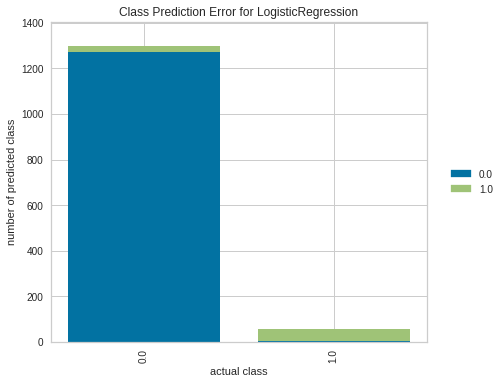

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lr, plot = 'error')

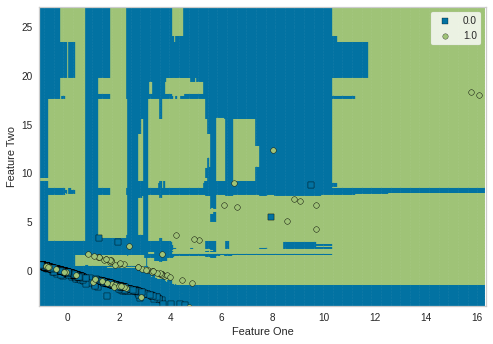

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_gbc, plot='boundary')

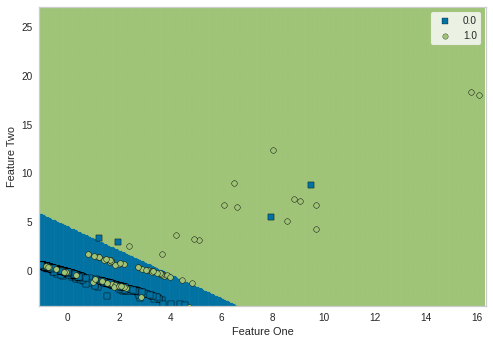

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lr, plot='boundary')

**Conclusão**
- Podemos concluir que ao longo dos teste 

**Relatório dos Dados em Gráfico**
- FASE 12: Criação do gráfico de valor do score por indice de atrito, para checar se há relação das pessoas que possuem maior score terem um indice maior de atrito.

In [ ]:
#Criação do gráfico com seus repectivos dados
fig = px.area(dados_preparados, x='ind_atrito', y='vlr_score', height=300, width=600)
#Atualização dos gráficos
fig.update_xaxes(type='category')
#Vizualiação do gráfico
fig.show()

**Seleção das Colunas dos Dados**
- FASE 13: Seleção de todas as colunas escolhidas no foco de treinamento da IA. Esses campos foram escolhidos por meio da estimativa de existir correlação entre algumas colunas 'qtd_reclm', 'num_atend_atrs', 'num_atend', 'ind_atrito', 'cod_rating' e 'vlr_score' que ajudaram na fase de treinamento, afim de gerar o modelo preditivo.
- Não estão sendo usadas todas as colunas pois algumas delas poderiam gerar vieses nos resultados e assim, o treinamento não seria tão efetivo.

In [ ]:
#Colunas escolhidas da base de dados para serem utilizadas
colunas_para_treinamento = ['qtd_reclm','num_atend','ind_atrito','vlr_score','num_produtos','cod_rating','ind_engaj','num_atend_atrs']

**Train-test split**
- Fase 14: Separação de dados para treino e teste para o modelo
- Facilitando assim a separação dos dados para o treinamento e teste do modelo

In [ ]:
dados_preparados = selecao_safra(202104,1000)

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=42)

In [ ]:
#Dividindo x e y

dados_preparados = dados_preparados[colunas_para_treinamento]

x = dados_preparados.drop(columns="ind_atrito").values
y = dados_preparados['ind_atrito']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.5, 
                                                    random_state = 10)


In [ ]:
X_train_resamble, Y_train_resamble = sm.fit_resample(x_train, y_train)

In [ ]:
#X_test_resamble, Y_test_resamble = sm.fit_resample(x_test, y_test)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier

**Criação dos Modelos para inicar as FASES de treinamento do seu respectivo modelo**
- FASE 15: Nesta fase optamos por gerar e o treinamento de todos os modelos possiveis para posteriormente julgar o melhor que se enquadrar no cenario para ser utilizado, por meio da analise da Acuracia, Revocação e Precisão.

**Modelo SVM**
- A Criação modelo SVM 
- Treinamento do modelo SVM

In [ ]:
# Modelo SVM

clf = svm.SVC()
clf.fit(X_train_resamble, Y_train_resamble)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Modelo KNN**
- A Criação também do modelo KNN
- E o seu treinamento de modelo KNN


In [ ]:
# Modelo KNN

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_resamble, Y_train_resamble)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

**Random Forest Model**
- Criação do modelo Random Forest Model
- Treinamento de modelo Random Forest Model

In [ ]:
# Modelo Random Forest Model

rfcModel = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_estimators=120, warm_start=True)
rfcModel.fit(X_train_resamble, Y_train_resamble)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=120, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=True)

**Modelo de Arvore de decisão**
- Criação do modelo Arvore de decisão
- Treimento do modelo Arvore de decisão

In [ ]:
# Treinando o modelo

model = DecisionTreeClassifier(criterion='entropy',random_state = 10)
model.fit(X_train_resamble, Y_train_resamble)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [ ]:
linear =  LinearDiscriminantAnalysis()
linear.fit(X_train_resamble, Y_train_resamble)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
grandi = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,random_state=10)
grandi.fit(X_train_resamble, Y_train_resamble)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
rigde =  RidgeClassifier()
rigde.fit(X_train_resamble, Y_train_resamble)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

**Validação dos modelos**
- FASE 16: Fazer a validação de cada modelo com os seguintes teste: Acuracia, Revocação e Precisão.
- Pois assim facilita a escolha e a decição de qual modelo usaremos futuramente

--------------SVM---------------
Acuracia: 0.654
Revocação: 0.7297297297297297
Precisão: 0.8059701492537313


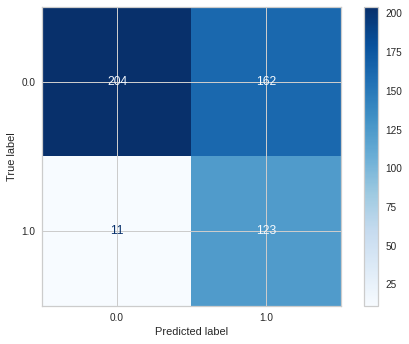

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento svm

from sklearn import metrics

print("--------------SVM---------------")
print("Acuracia:" , clf.score(x_test, y_test))
y_pred_clf = model.predict(x_test)
plot_confusion_matrix(clf, x_test, y_test, cmap='Blues')
print("Revocação:",metrics.recall_score(y_pred_clf , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_clf , y_test, average="binary"))

--------------KNN---------------
Acuracia: 0.72
Revocação: 0.4819277108433735
Precisão: 0.5970149253731343


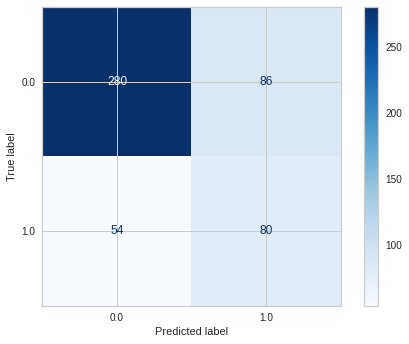

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento KNN
print("--------------KNN---------------")
print("Acuracia:",knn_model.score(x_test, y_test))
y_pred_knn = knn_model.predict(x_test)
plot_confusion_matrix(knn_model, x_test, y_test, cmap='Blues')
print("Revocação:",recall_score(y_pred_knn , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_knn , y_test, average="binary"))

--------------Arvore de decisão---------------
Acuracia: 0.868
Revocação: 0.7297297297297297
Precisão: 0.8059701492537313


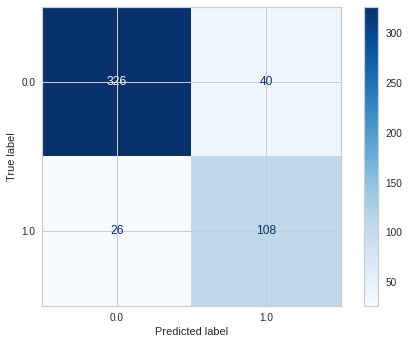

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento Arvore de decisão
print("--------------Arvore de decisão---------------")
print("Acuracia:",model.score(x_test, y_test))
y_pred_tree = model.predict(x_test)
plot_confusion_matrix(model, x_test, y_test, cmap='Blues')
print("Revocação:",recall_score(y_pred_tree , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_tree , y_test, average="binary"))

--------------Random Forest Model---------------
Acuracia: 0.878
Revocação: 0.7664233576642335
Precisão: 0.7835820895522388


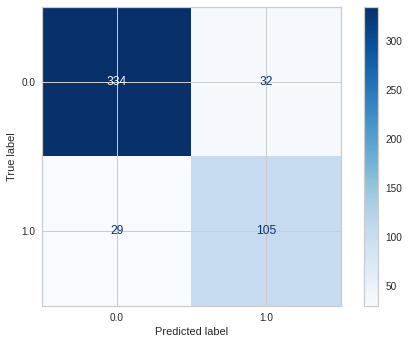

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento Random Forest Model
print("--------------Random Forest Model---------------")
y_pred_rcf = rfcModel.predict(x_test)
plot_confusion_matrix(rfcModel, x_test, y_test, cmap='Blues')
print("Acuracia:",rfcModel.score(x_test, y_test))
print("Revocação:",recall_score(y_pred_rcf,y_test, average="binary"))
print("Precisão:",precision_score(y_pred_rcf,y_test, average="binary"))

--------------LinearDiscriminantAnalysis---------------
Acuracia: 0.878
Revocação: 0.7664233576642335
Precisão: 0.7835820895522388


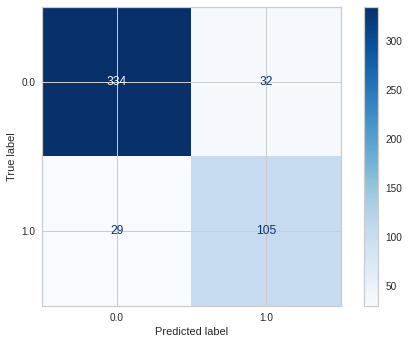

In [ ]:
print("--------------LinearDiscriminantAnalysis---------------")
y_pred_lin = linear.predict(x_test)
plot_confusion_matrix(linear, x_test, y_test, cmap='Blues')
print("Acuracia:",linear.score(x_test, y_test))
print("Revocação:",recall_score(y_pred_lin,y_test, average="binary"))
print("Precisão:",precision_score(y_pred_lin,y_test, average="binary"))

--------------GradientBoostingClassifier---------------
Acuracia: 0.874
Revocação: 0.762962962962963
Precisão: 0.7686567164179104


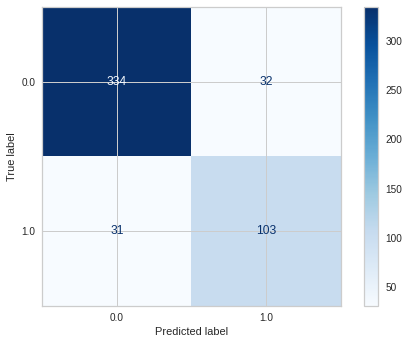

In [ ]:
print("--------------GradientBoostingClassifier---------------")
y_pred_gra = grandi.predict(x_test)
plot_confusion_matrix(grandi, x_test, y_test, cmap='Blues')
print("Acuracia:",grandi.score(x_test, y_test))
print("Revocação:",recall_score(y_pred_gra,y_test, average="binary"))
print("Precisão:",precision_score(y_pred_gra,y_test, average="binary"))

--------------RidgeClassifier---------------
Acuracia: 0.878
Revocação: 0.7588652482269503
Precisão: 0.7985074626865671


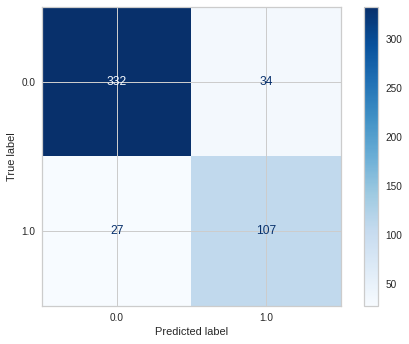

In [ ]:
print("--------------RidgeClassifier---------------")
y_pred_rig = rigde.predict(x_test)
plot_confusion_matrix(rigde, x_test, y_test, cmap='Blues')
print("Acuracia:",rigde.score(x_test, y_test))
print("Revocação:",recall_score(y_pred_rig,y_test, average="binary"))
print("Precisão:",precision_score(y_pred_rig,y_test, average="binary"))

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

<h1>Não rodar essa cedula</h1>

In [ ]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'n_estimators':[80,90,100,110,120],
              'criterion':["gini", "entropy", "log_loss"],
              "class_weight":["balanced", "balanced_subsample"],
              "warm_start":[True, False],
              "verbose":range(1,70,5)}
            
#grid_search = GridSearchCV(estimator = RandomForestClassifier() , param_grid=parametros)
#grid_search.fit(x_train, y_train.squeeze())

In [ ]:
#print(grid_search.best_score_)
#print(grid_search.best_params_)

In [ ]:
randomized_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=parametros)
randomized_search.fit(x_train, y_train.squeeze())

In [ ]:
print(randomized_search.best_score_)
print(randomized_search.best_params_)